In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import glob
import os
from scipy import misc
import math

import gc
import timeit

In [2]:
for phase in glob.glob('data/phase*'):
    print(phase)

data/phase3
data/phase2
data/phase1
data/phase7
data/phase5
data/phase4
data/phase6


In [3]:
'''
From traffic light msg
uint8 UNKNOWN=4
uint8 GREEN=2
uint8 YELLOW=1
uint8 RED=0
'''

state = {0: 'Red', 1: 'Yellow', 2: 'Green', 3: 'Unknown'}

paths = ['red/*.png', 'yellow/*.png', 'green/*.png', 'other/*.png']

X_all = []
y_all = []
hash_set = set()
for phase in glob.glob('data/phase*'):
    for i, path in enumerate(paths):
        for infile in glob.glob(phase+'/'+path):
            img = misc.imread(infile)
            for mode in ['nearest', 'cubic']:
                img = misc.imresize(img, (24, 24), interp=mode)
                img_hash = hash(img.data.tobytes())
                if img_hash not in hash_set:
                    hash_set.add(img_hash)
                    X_all.append(img)
                    label = np.zeros(4)
                    label[i] = 1
                    y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)
n_labels = len(y_all[0])
print("{} images loaded with {} classes.".format(len(X_all), n_labels))

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.10, random_state=121)
print("Train Size: {}".format(len(y_train)))
print("Test Size: {}".format(len(y_test)))

12743 images loaded with 4 classes.
Train Size: 11468
Test Size: 1275


In [31]:
X_all[0][0][0]

array([169, 202, 233], dtype=uint8)

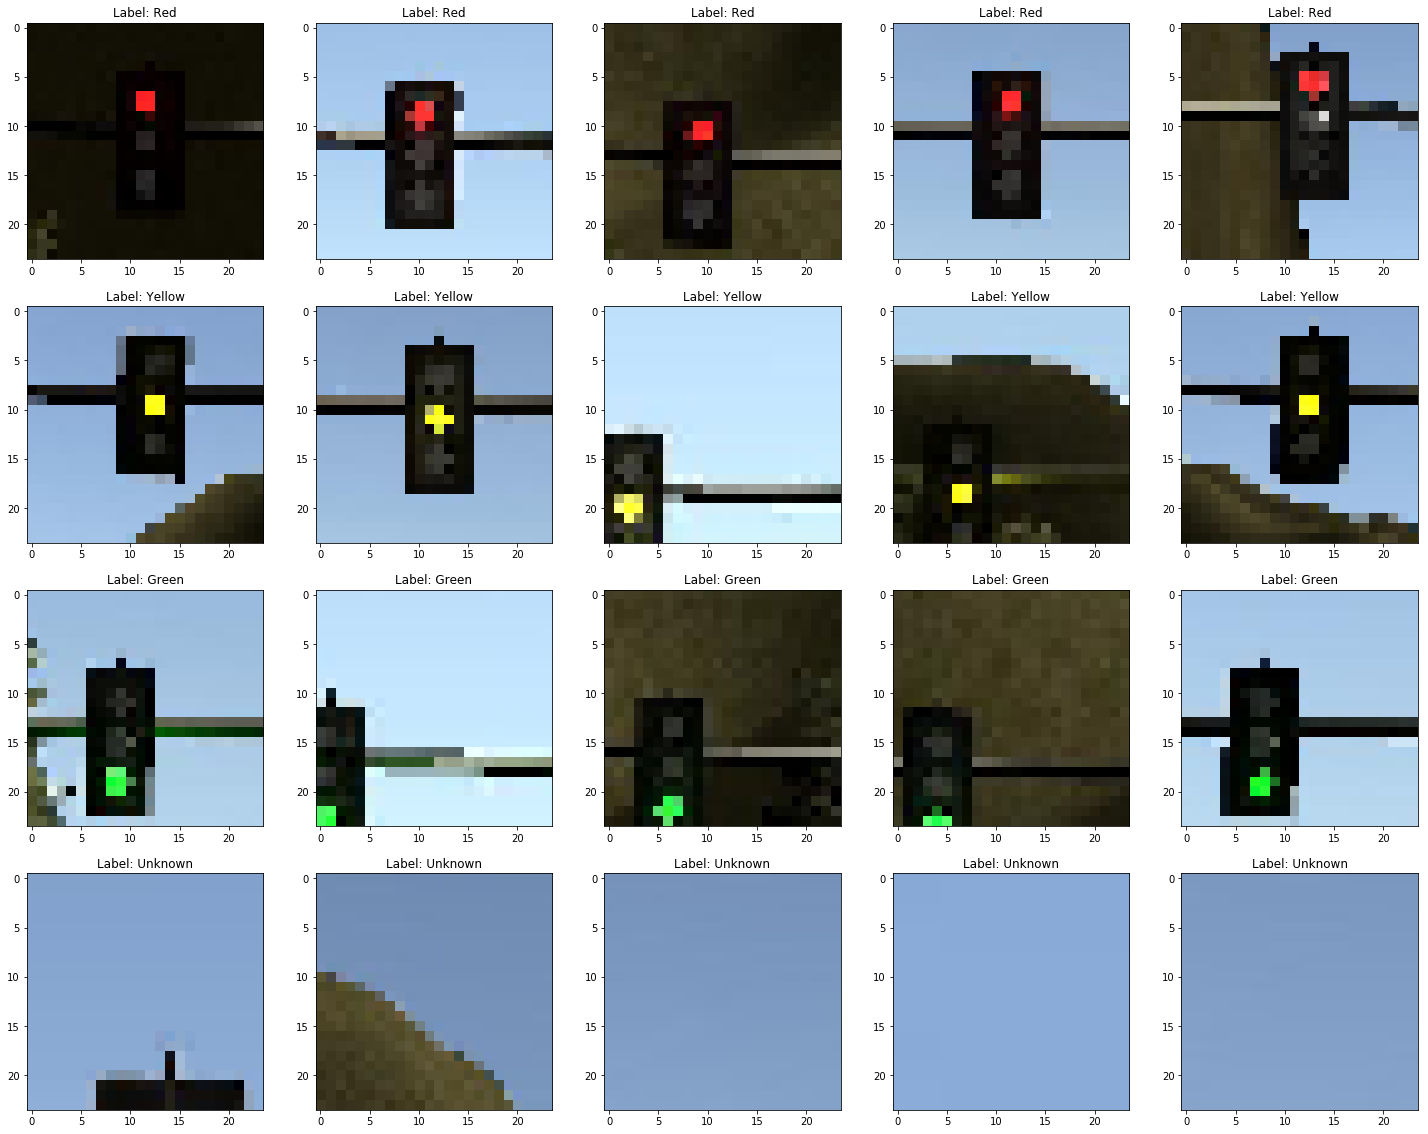

In [4]:
n_examples = 5
plt.subplots(figsize=(5*n_examples, 5*n_labels))
plt_index = 1
for i  in range(len(y_all[0])):
    X_i = X_all[y_all[:,i] == 1]
    for img_index in np.random.randint(0, len(X_i), n_examples):
        plt.subplot(n_labels, n_examples, plt_index)
        plt.imshow(X_i[img_index])
        plt.title("Label: {}".format(state[i]))
        plt_index += 1
plt.show()    

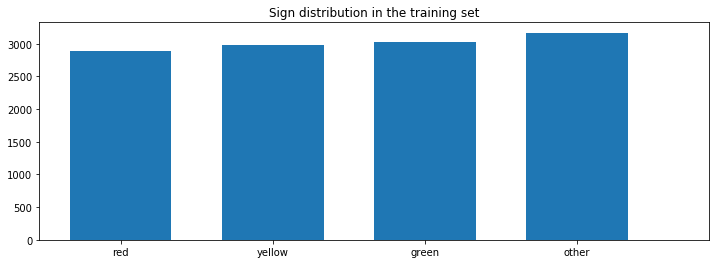

In [33]:
# Look at the distribution of training signs
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = plt.subplot(111)
width = 0.5
ax.hist(np.argmax(y_all, axis=1), bins=n_labels, width=width)
ax.set_xticks([0.25,1,1.75,2.5])
ax.set_xticklabels(['red', 'yellow', 'green', 'other'], rotation=0)
plt.title("Sign distribution in the training set")
plt.show()

In [34]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [35]:
def simple_FCN():
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(12, (3, 3),
                     strides=1,
                     padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))

    # Conv layer 2
    model.add(Conv2D(6, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Conv layer 3
    model.add(Conv2D(num_classes, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Global max pool to output
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))
    return model


def compress_FCN():
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(12, (3, 3),
                     strides=1,
                     padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    
    # Pool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Conv layer 2
    model.add(Conv2D(6, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Pool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Conv layer 3
    model.add(Conv2D(num_classes, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Global max pool to output
    model.add(GlobalMaxPooling2D())
    model.add(Activation('softmax'))
    return model

def CNN():
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(32, (3, 3),
                     strides=1,
                     padding='same',
                     input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    
    # Pool layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Conv layer 2
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # Pool layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Conv layer 3
    model.add(Conv2D(8, (3, 3), padding='same'))
    model.add(Activation('relu'))

    # FC layers
    model.add(Flatten())
    model.add(Dense(24))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes))

    model.add(Activation('softmax'))
    return model

In [36]:
batch_size = 5
num_classes = 4
epochs = 30
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'trained_model.h5'

# The data, shuffled and split between train and test sets:
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# call model
# model = simple_FCN()
# model = compress_FCN()
model = CNN()

# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

# Compile traininer with loss and optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    
    # Setup early stopping on validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    
    # Fit
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True,
              callbacks=[early_stopping])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Setup early stopping on validation loss
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        workers=4,
                        callbacks=[early_stopping])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (10857, 24, 24, 3)
10857 train samples
1207 test samples
Using real-time data augmentation.
Epoch 1/30
2171/2171 [==============================] - 17s - loss: 7.0477 - acc: 0.3499 - val_loss: 1.2918 - val_acc: 0.5510
Epoch 2/30
2171/2171 [==============================] - 16s - loss: 1.4865 - acc: 0.4314 - val_loss: 1.0615 - val_acc: 0.5742
Epoch 3/30
2171/2171 [==============================] - 16s - loss: 0.9983 - acc: 0.5326 - val_loss: 0.7053 - val_acc: 0.6910
Epoch 4/30
2171/2171 [==============================] - 15s - loss: 0.6863 - acc: 0.6922 - val_loss: 0.3277 - val_acc: 0.8948
Epoch 5/30
2171/2171 [==============================] - 16s - loss: 0.4141 - acc: 0.8334 - val_loss: 0.1692 - val_acc: 0.9768
Epoch 6/30
2171/2171 [==============================] - 16s - loss: 0.2393 - acc: 0.9124 - val_loss: 0.0632 - val_acc: 0.9876
Epoch 7/30
2171/2171 [==============================] - 16s - loss: 0.1261 - acc: 0.9568 - val_loss: 0.0335 - val_acc: 0.9959
Epoch 8/30


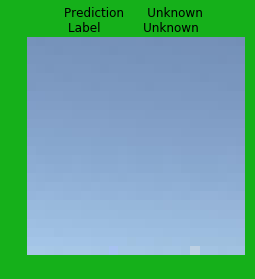

In [37]:
index = np.random.randint(0, len(X_all))
img = X_all[index]
prediction = np.argmax(model.predict(np.array([img])))
label = np.argmax(y_all[index])
if prediction == label:
    plt.figure(facecolor='xkcd:green')
else:
    plt.figure(facecolor='xkcd:red')
plt.imshow(img)
plt.title("{:15} {:8}\n{:15} {:8}".format("Prediction", state[prediction], "Label", state[label]))
plt.axis('off')
plt.show()

In [38]:
gc.collect()

4374

In [7]:
from keras.models import load_model
import numpy as np
    
# model = load_model('saved_models/trained_model.h5')
model = load_model('saved_models/CNN_trained_model.h5')
img = X_all[0]
np.argmax(model.predict(np.array([img])))

0

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 24, 24, 32)        896       
_________________________________________________________________
activation_16 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 16)        4624      
_________________________________________________________________
activation_17 (Activation)   (None, 12, 12, 16)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 6, 6, 16)          0         
__________

In [40]:
from timeit import Timer

def predict(images):
        return model.predict(images)

def get_images(n):
    index_list = np.random.randint(0, len(X_all), n)
    images = []
    labels = []
    for i in index_list:
        images.append(X_all[i])
        labels.append(y_all[i])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    

# first argument is the code to be run, the second "setup" argument is only run once,
# and it not included in the execution time.
t = Timer('predict(images)', setup='from __main__ import predict, get_images; images, _ = get_images(100)')
# t = Timer('predict(images, 100)')

n = 200
time = t.timeit(n)
print("{:6.5f}".format(time))
# timeit.timeit('char in text', setup='text = "sample string"; char = "g"')

1.78549


2.00407     4 layer with final conv 3x3 to num classes
2.00286     3 layer with final conv 3x3 to num classes
1.91434     3 layer 16->8->num_classes
1.49570     48x48 img to 32x32 image
1.47931     32x32 img to 24x24 image

In [41]:
# images, labels = get_images(1000)
images = X_all
labels = y_all
conf = predict(images)
pred = np.argmax(conf, axis=1)
correct = np.argmax(labels, axis=1) == pred

labels = np.argmax(labels, axis=1)

print("{:4.3}% Correct".format(100*len(correct[correct==True])/len(correct)))
wrong = np.where(correct==False)
n_wrong = len(wrong[0])
print("{} wrong out of {}".format(n_wrong, len(images)))

99.9% Correct
16 wrong out of 12064


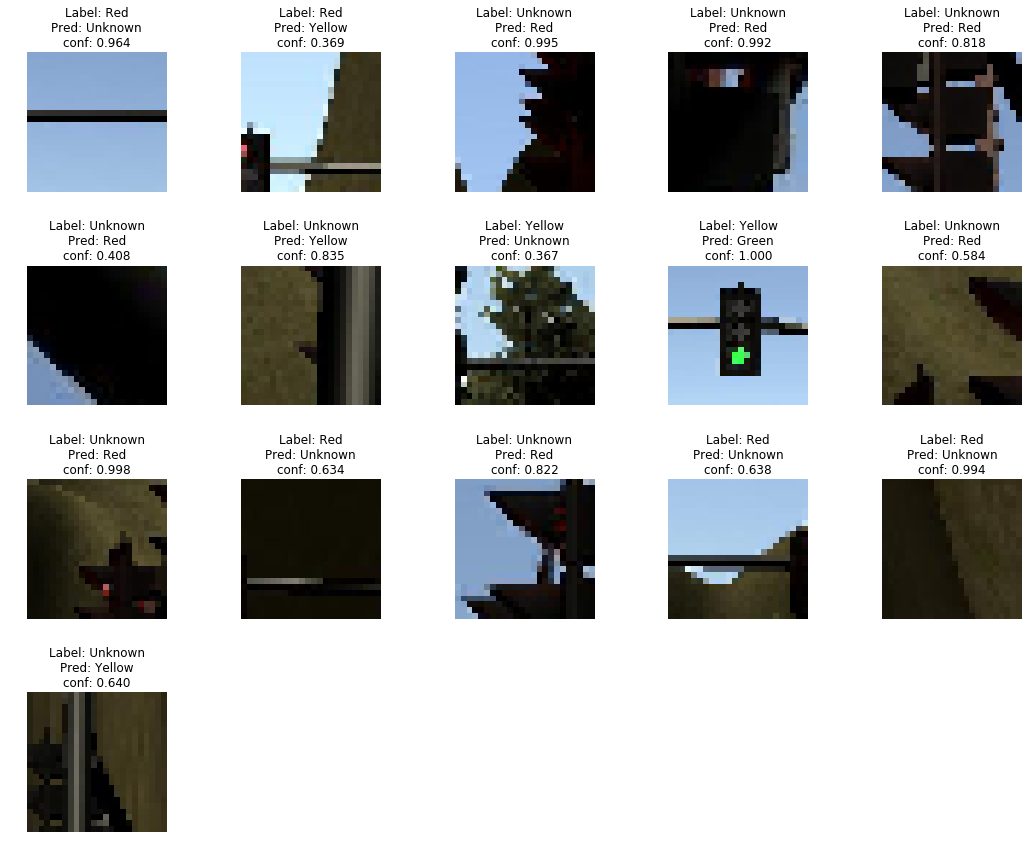

In [42]:
cols = 5
rows = n_wrong//cols+1
plt.subplots(figsize=(3*cols,3*rows))
i = 1
for i, (img, l, p, c) in enumerate(zip(images[wrong], labels[wrong], pred[wrong], conf[wrong])):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title("Label: {}\nPred: {}\nconf: {:.3f}".format(state[l], state[p], c[p]))
    plt.axis('off')
plt.tight_layout()
plt.show()